In [7]:
import numpy as np
import os
import cv2
import matplotlib
import matplotlib.pyplot as plt

from matplotlib.font_manager import fontManager
#for i in sorted(fontManager.get_font_names()):
#    print(i)
matplotlib.rc('font', family='Microsoft JhengHei')


In [8]:
import dark_channel
import CAP_recover
import local_minimum
import atmospheric_light

- CAP main

In [9]:
def CAP_main_dehaze(image_name, beta):

    image = (cv2.imread(image_name).astype(np.float32))/255.0

    dc = dark_channel.dark_channel(image)
    A = atmospheric_light.atmospheric_light(image, dc)

    image_bgr2hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    _, s, v = cv2.split(image_bgr2hsv)

    H, W, _ = image.shape
    sigma = 0.041337
    sigmaMat = np.random.normal(0, sigma, (H, W)).astype(np.float32)
    d = 0.121779 + 0.959710*v - 0.780245*s + sigmaMat
    local_min_d = local_minimum.local_minimum(d)
    GF_d = cv2.ximgproc.guidedFilter(guide=image, src=local_min_d, radius=15, eps=1e-3)

    result_dehaze, t, clip_t = CAP_recover.CAP_recover(image, A, GF_d, beta)

    return image, dc, sigmaMat, d, local_min_d, GF_d, t, clip_t, result_dehaze


- total main

In [10]:
input_folder  = "my dataset"
output_folder = "my result"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

image_count = 0

for filename in os.listdir(input_folder):
    if filename.endswith(".png"):
        image_count += 1
        image_path = os.path.join(input_folder, filename)
        file_base_name = os.path.splitext(filename)[0]
        print(file_base_name)

        individual_output_folder = os.path.join(output_folder, f"{file_base_name}")
        if not os.path.exists(individual_output_folder):
            os.makedirs(individual_output_folder)

        image, dc, sigmaMat, d, local_min_d, GF_d, t, clip_t, CAP_beta_10 = CAP_main_dehaze(image_path, beta = 1.0)

        output_path_ori = os.path.join(individual_output_folder, f"{file_base_name}.png")
        cv2.imwrite(output_path_ori, (image * 255).astype(np.uint8))

        output_path_d = os.path.join(individual_output_folder, f"d ({file_base_name}).png")
        cv2.imwrite(output_path_d, (np.clip(d, 0, 1) * 255).astype(np.uint8))
        output_path_local_min_d = os.path.join(individual_output_folder, f"local_min_d ({file_base_name}).png")
        cv2.imwrite(output_path_local_min_d, (np.clip(local_min_d, 0, 1) * 255).astype(np.uint8))
        output_path_GF_d = os.path.join(individual_output_folder, f"GF_d ({file_base_name}).png")
        cv2.imwrite(output_path_GF_d, (np.clip(GF_d, 0, 1) * 255).astype(np.uint8))

        output_path_t = os.path.join(individual_output_folder, f"t ({file_base_name}).png")
        cv2.imwrite(output_path_t, (np.clip(t, 0, 1) * 255).astype(np.uint8))
        output_path_clip_t = os.path.join(individual_output_folder, f"clip_t ({file_base_name}).png")
        cv2.imwrite(output_path_clip_t, (clip_t * 255).astype(np.uint8))

        output_path_CAP10 = os.path.join(individual_output_folder, f"my_CAP beta=1.0 ({file_base_name}).png")
        cv2.imwrite(output_path_CAP10, (CAP_beta_10 * 255).astype(np.uint8))


print("===========================================================")
# print("\n")
print(f"總共讀入了 {image_count} 張圖片")

40
cityscape
cones
forest
總共讀入了 4 張圖片


plot

In [11]:
def plot__BGR(h, w, num, image, title):
    plt.subplot(h, w, num)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")

def plot_gray(h, w, num, image, title):
    plt.subplot(h, w, num)
    plt.imshow(image, cmap = 'gray', vmin=0, vmax=1)
    plt.title(title)
    plt.axis("off")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


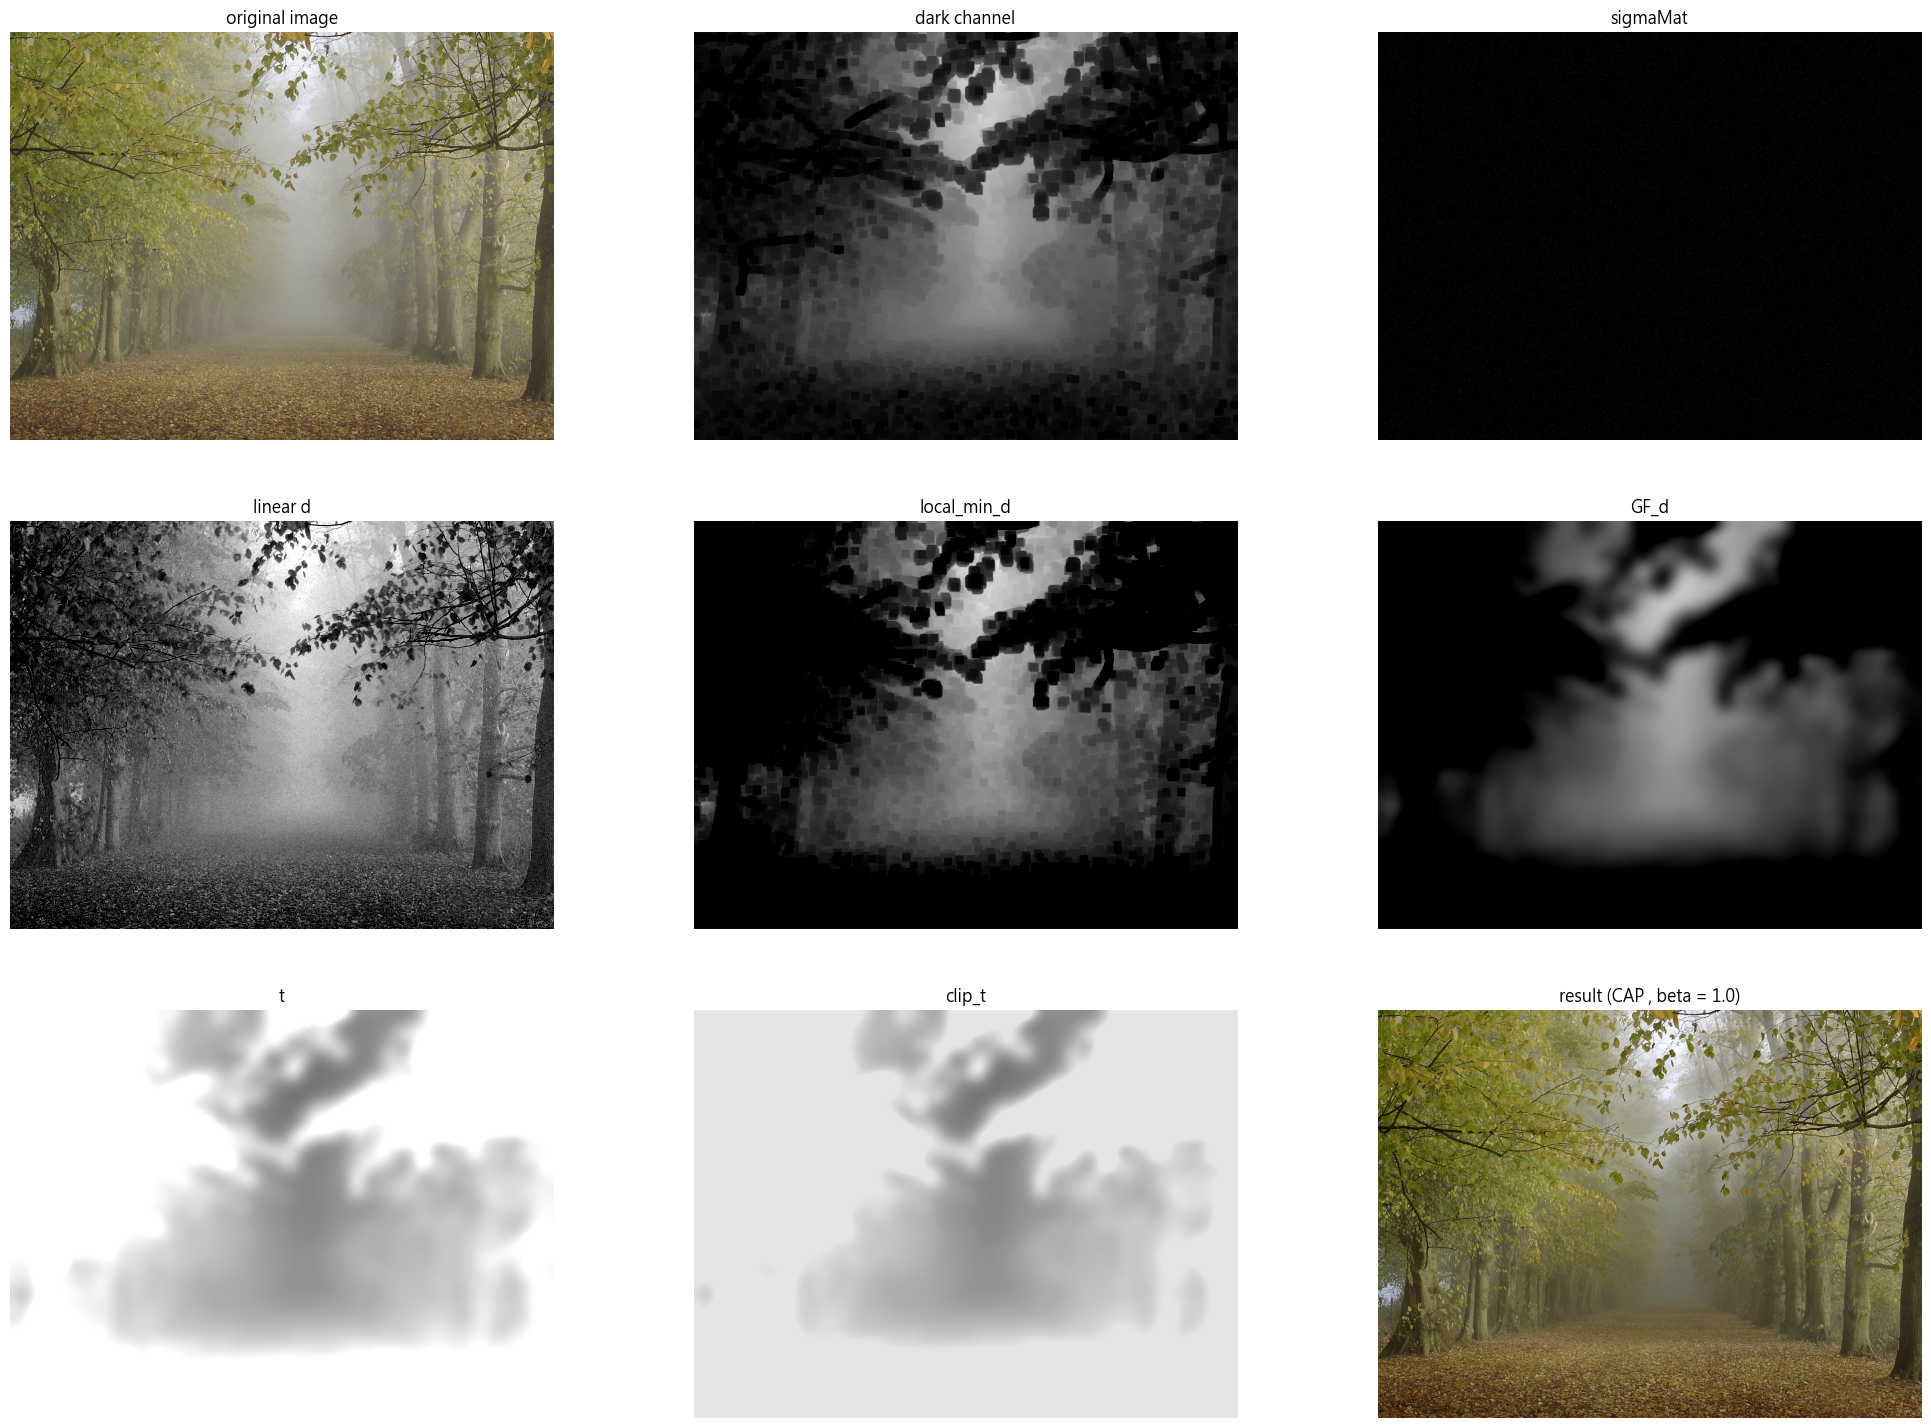

In [12]:
plt.figure(figsize=(25, 18))
h, w = 3, 3

plot__BGR(h, w, 1, image,           "original image"              )
plot_gray(h, w, 2, dc,              "dark channel"                )
plot_gray(h, w, 3, sigmaMat,        "sigmaMat"                    )
plot_gray(h, w, 4, d,               "linear d"                    )
plot_gray(h, w, 5, local_min_d,     "local_min_d"                 )
plot_gray(h, w, 6, GF_d,            "GF_d"                        )
plot__BGR(h, w, 7, t,               "t"                           )
plot__BGR(h, w, 8, clip_t,          "clip_t"                      )
plot__BGR(h, w, 9, CAP_beta_10,     "result (CAP , beta = 1.0)"   )


# plt.tight_layout()
plt.show()